In [1]:
import pydrake
from pydrake.all import (
    MathematicalProgram,
    MakeSolver,
    MosekSolver,
    IpoptSolver,
    Solve
)
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

Minimal grammar definition: each node has:
- a pose x
- a type name

A node class defines:
- its child type (by name or None)
- max # of children
- the geometric stop prob p (1. = always 0 children, 1. = infinite children)
- the region in which children will be produced, in the frame of the node

E.g. object groups in plane:
- Root node produces object clusters and uniform random locations inside [0, 1]^2.
- Each cluster produces up points uniformly in a 0.1-length box centered at the cluster center.

Text(0.5, 1.0, 'Observed nodes')

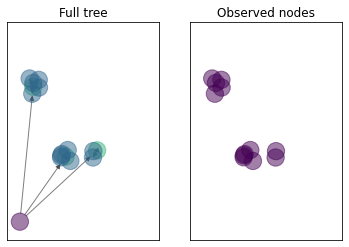

In [2]:
# Minimal grammar definition:
from collections import namedtuple
NodeDefinition = namedtuple("NodeDefinition",
    ["child_type",   # name of child type or None,
     "max_children", # max # of children
     "p",            # geometric keep-going probability
     "bounds"        # Generation bounds for children relative to node x
    ])
class Node():
    def __init__(self, type, x):
        self.x = x
        self.type = type

def sample_tree(grammar):
    tree = nx.DiGraph()
    root = Node("root", x=np.array([0., 0.]))
    tree.add_node(root)
    node_queue = [root]
    
    while len(node_queue) > 0:
        parent = node_queue.pop(0)
        assert parent.type in grammar.keys()
        parent_def = grammar[parent.type]
        if parent_def.child_type is None:
            continue
        n_children = min(np.random.geometric(parent_def.p), parent_def.max_children)

        for k in range(n_children):
            child_x = parent.x + np.random.uniform(*parent_def.bounds)
            child = Node(parent_def.child_type, child_x)
            tree.add_node(child)
            tree.add_edge(parent, child)
            node_queue.append(child)
    return tree

cluster_grammar = {
    "point": NodeDefinition(child_type=None, p=None, max_children=None, bounds=None),
    "cluster": NodeDefinition(child_type="point", p=0.1, max_children=5, bounds=[-np.ones(2)*0.05, np.ones(2)*0.05]),
    "root": NodeDefinition(child_type="cluster", p=0.25, max_children=3, bounds=[np.zeros(2), np.ones(2)])
}
cluster_grammar_observed_types = ["point"]

def get_observed_nodes(tree, observed_types):
    return [n for n in tree if n.type in observed_types]

def draw_tree(tree, draw_pos=True, with_labels=False):
    # Decide a coloring for the node tpyes.
    unique_types = list(set([n.type for n in tree]))
    n_types = len(unique_types)
    cm = plt.get_cmap("viridis")
    color_mapping = {unique_type: cm(float(k)/n_types) for k, unique_type in enumerate(unique_types)}
    if draw_pos:
        pos={node: node.x for node in tree}
    else:
        pos=None
    nx.draw_networkx(
        tree,
        labels={node: node.type for node in example_tree},
        with_labels=with_labels,
        pos=pos,
        node_color=[color_mapping[node.type] for node in tree],
        alpha=0.5
    )
def draw_observed_nodes(nodes):
    tree = nx.Graph()
    tree.add_nodes_from(nodes)
    draw_tree(tree)
    
np.random.seed(44)
example_tree = sample_tree(cluster_grammar)
observed_nodes = get_observed_nodes(example_tree, cluster_grammar_observed_types)

plt.subplot(1, 2, 1)
draw_tree(example_tree)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title("Full tree")
plt.subplot(1, 2, 2)
draw_observed_nodes(observed_nodes)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title("Observed nodes")

Mixed integer parsing strategy:
- Build the "super tree" of node types in the grammar: the scene tree (of types) that would result if every possible child node was produced.
- Add a binary variable on each edge of the super tree, indicating whether that edge is active.
  - (Constraint: a node can't be active if its direct parent isn't active.)
- Add an edge from every observed node to every node in the super tree that could have produced it.
  - (Constraint: each observed node is explained by exactly one node in the tree.)

Text(0.5, 1.0, 'Super tree for cluster grammar')

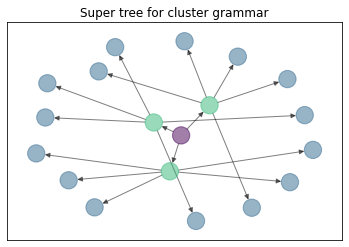

In [3]:
def make_super_tree(grammar):
    # Same logic as sampling a tree, but instead takes *all*
    # choices (but doesn't bother with sampling x).
    tree = nx.DiGraph()
    root = Node("root", x=np.array([0., 0.]))
    tree.add_node(root)
    node_queue = [root]
    
    while len(node_queue) > 0:
        parent = node_queue.pop(0)
        assert parent.type in grammar.keys()
        parent_def = grammar[parent.type]
        if parent_def.child_type is None:
            continue
        n_children = parent_def.max_children

        for k in range(n_children):
            child = Node(parent_def.child_type, np.zeros(2))
            tree.add_node(child)
            tree.add_edge(parent, child)
            node_queue.append(child)
    return tree
super_tree = make_super_tree(cluster_grammar)
draw_tree(super_tree, draw_pos=False)
plt.title("Super tree for cluster grammar")

In [4]:
# Make super tree which we'll modify to organize our optimization variables.
super_tree = make_super_tree(cluster_grammar)

prog = MathematicalProgram()

# Every node gets a binary variable to indicate
# whether it's active or node. This is equivalent to a
# binary variable on the incoming edge for the node.
active_vars = prog.NewBinaryVariables(len(super_tree.nodes), "nodes_active")
for k, node in enumerate(super_tree.nodes):
    node.active = active_vars[k]

# For each node in the tree, its children should only be active if the
# parent is active.
for parent_node in super_tree:
    children = list(super_tree.successors(parent_node))
    child_actives = [c.active for c in children]
    
    # Bookkeeping
    parent_node.child_actives = child_actives

    # Children active implies parent active
    prog.AddLinearConstraint(parent_node.active >= sum(child_actives))
    
    # Geometric node special case to reduce duplicate parse: a child can
    # only be active if the previous child is also active.
    for k in range(len(child_actives) - 1):
        # child_{k+1} implies child_k
        # i.e. child_k >= child_{k+1}
        prog.AddLinearConstraint(child_actives[k] >= child_actives[k+1])

# For each observed node, add a binary variable for each possible
# correspondence to a node in the observed set.
for n in super_tree:
    # (first prep some bookkeeping)
    n.outgoings = []
for observed_node in observed_nodes:
    possible_sources = [n for n in super_tree if n.type == observed_node.type]
    source_actives = prog.NewBinaryVariables(len(possible_sources), observed_node.type + "_sources")
    
    # Store these variables
    observed_node.source_actives = source_actives
    for k, n in enumerate(possible_sources):
        n.outgoings.append(source_actives[k])

    # Each observed node needs only one explaining input.
    prog.AddLinearEqualityConstraint(sum(source_actives) == 1)
    
# Go back and make sure no node in the super tree is being used
# to explain more than one observed node, and that a node can
# only explain observed nodes if it's active (i.e. its incoming
# binary var is 1).
for node in super_tree:
    if len(node.outgoings) > 0:
        prog.AddLinearConstraint(node.active >= sum(node.outgoings))

result = Solve(prog)

RuntimeError: Could not create Gurobi environment because Gurobi returned code 10009 with message "License expired 2020-05-20 - license file '/home/gizatt/gurobi801.lic'".